# Imports

In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import pandas as pd
import plotly.graph_objects as go


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Data preprocessing

In [2]:
# make df with column names year, month, decimal date, SSN, M1, M2, M3, M4, M5 from file 5c_obs_sim_v1.dat
df = pd.read_csv('5c_obs_sim_v1.dat', sep='\s+', header=None, names=['year', 'month', 'decimal_date', 'SSN', 'M1', 'M2', 'M3', 'M4', 'M5'])

# normalize data to be between 0 and 1 using max value from SSN
observed_series = df['SSN'].values
model_series = df['M1'].values
M = np.max(observed_series)
observed_series = observed_series / M
model_series = model_series / M


In [14]:
class MixedDataGenerator:
    def __init__(self,
                 model_series,
                 observed_series,
                 previous_values,
                 horizon=18):
        self.model_series = model_series
        self.observed_series = observed_series
        self.horizon = horizon
        self.n_prev = previous_values
        self.X, self.y = self._prepare_data()
        
    def _prepare_data(self):
        l = len(self.model_series) - self.n_prev - self.horizon + 1
        X = np.zeros((l, 2 * self.n_prev + self.horizon))
        y = np.zeros((l, self.horizon))
        for i in range(l):
            X[i, -self.n_prev:] = self.observed_series[i:i + self.n_prev]
            X[i, :-self.n_prev] = self.model_series[i:i + self.n_prev + self.horizon]
            
            # X[i, :self.n_prev] = self.observed_series[i:i + self.n_prev]
            # X[i, self.n_prev:] = self.model_series[i:i + self.n_prev + self.horizon]
            
            y[i] = self.observed_series[i + self.n_prev: i + self.n_prev + self.horizon]
        return torch.tensor(X, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)
        
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [15]:
data = MixedDataGenerator(model_series, observed_series, 4, 18)

In [16]:
train_data_X = data.X[:360]
train_data_y = data.y[:360]


test_data_X = data.X[360:]
test_data_y = data.y[360:]

trainloader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(train_data_X, train_data_y), batch_size=64, shuffle=True)

# Model building

In [27]:
import torch
import torch.nn as nn
import numpy as np
from tqdm import tqdm

class NARX(nn.Module):
    def __init__(self, input_size, hidden_sizes, output_size):
        super(NARX, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_size, hidden_sizes[0]),
            nn.Sigmoid(),
            *[
                layer
                for i in range(len(hidden_sizes) - 1)
                for layer in (nn.Linear(hidden_sizes[i], hidden_sizes[i + 1]), nn.Sigmoid())
            ],
            nn.Linear(hidden_sizes[-1], output_size),
            nn.Softplus()
        )

    def forward(self, x):
        out = self.net(x)
        return out
    
    def train_model(self, trainloader, test_data_X, test_data_y, epochs=1000, lr=0.001):
        optimizer = torch.optim.Adam(self.parameters(), lr=lr)
        criterion = nn.MSELoss()
        train_losses = []
        rmse_epochs = []

        for epoch in tqdm(range(epochs), desc='Training', unit='epoch'):
            self.train()
            train_loss = 0
            for X, y in trainloader:
                X, y = X.to(device), y.to(device)
                optimizer.zero_grad()
                output = self(X)
                loss = criterion(output, y)
                loss.backward()
                optimizer.step()
                train_loss += loss.item()
            train_losses.append(train_loss / len(trainloader))
            
            # Каждые 500 эпох считаем RMSE
            if (epoch + 1) % 500 == 0:
                rmse = self.compute_rmse(test_data_X, test_data_y)
                rmse_epochs.append(rmse)
        return np.array(train_losses), np.array(rmse_epochs)
    
    def compute_rmse(self, test_data_X, test_data_y):
        prediction = self(test_data_X.to(device)).squeeze()
        prediction = prediction.cpu().detach()
        rmse = ((prediction - test_data_y).pow(2).mean(dim=0).sqrt() * M).numpy()
        return rmse

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [28]:
model = NARX(input_size=2*4+18, hidden_sizes=[24], output_size=18)
model.to(device)

NARX(
  (net): Sequential(
    (0): Linear(in_features=26, out_features=24, bias=True)
    (1): Sigmoid()
    (2): Linear(in_features=24, out_features=18, bias=True)
    (3): Softplus(beta=1, threshold=20)
  )
)

In [29]:
train_losses, rmses = model.train_model(trainloader, test_data_X, test_data_y, epochs=5000, lr=0.001)

Training: 100%|██████████| 5000/5000 [01:07<00:00, 73.65epoch/s]


(10, 18)

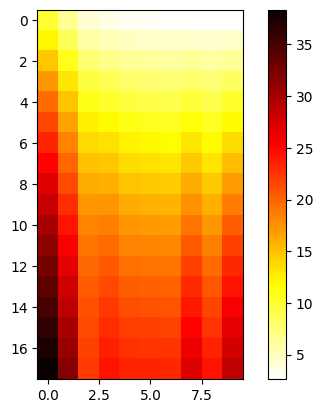

In [ ]:
plt.imshow(rmses.T, cmap='hot_r', interpolation='nearest')
plt.colorbar()

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import os

# Путь к папке, содержащей файлы
folder_path = 'RMSESx500-18-forward'

# Считывание всех файлов rmses_i.npy в папке
rmses_files = [os.path.join(folder_path, f"rmses_{i}.npy") for i in range(500)]

# Инициализация списка для хранения массивов
rmses_arrays = []

# Чтение каждого файла и добавление его в список
for file in rmses_files:
    rmses_arrays.append(np.load(file))

# Создание единого массива из всех считанных массивов
combined_rmses_array = np.stack(rmses_arrays)

# Вывод размера итогового массива
combined_rmses_array.shape


(500, 20, 18)

In [3]:
mean_rmses = np.mean(combined_rmses_array, axis=0)

In [ ]:
mean_rmses.shape

(20, 18)

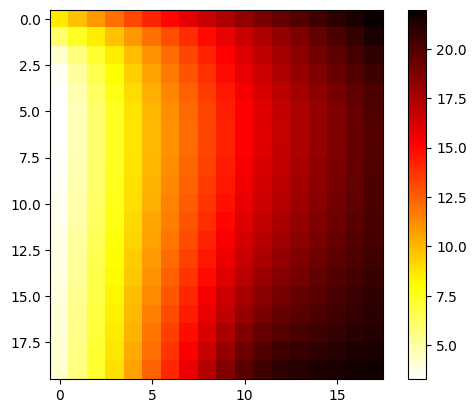

In [4]:
plt.imshow(mean_rmses, cmap='hot_r', interpolation='nearest')
plt.colorbar()



In [ ]:
import pandas as pd

In [ ]:
combined_rmses_array.shape, mean_rmses.shape

((500, 20, 18), (20, 18))

In [6]:
stds = np.std(combined_rmses_array, axis=0, ddof=1)

In [7]:
stds.shape

(20, 18)

In [ ]:
print('RMSE ошибки для 18 месяцев:')
for i, rmse in enumerate(mean_rmses):
    print(f'После {500 * (i + 1)} эпох:')
    for j, error in enumerate(rmse):
        print(f'Месяц {j + 1}: {error:.2f} +- {stds[i, j]:.2f}')
    print()


RMSE ошибки для 18 месяцев:
После 500 эпох:
Месяц 1: 9.84 +- 0.84
Месяц 2: 12.06 +- 0.82
Месяц 3: 14.45 +- 0.80
Месяц 4: 16.90 +- 0.82
Месяц 5: 19.25 +- 0.89
Месяц 6: 21.14 +- 0.85
Месяц 7: 22.94 +- 0.81
Месяц 8: 24.64 +- 0.77
Месяц 9: 26.24 +- 0.74
Месяц 10: 27.75 +- 0.71
Месяц 11: 29.18 +- 0.71
Месяц 12: 30.52 +- 0.73
Месяц 13: 31.78 +- 0.79
Месяц 14: 32.96 +- 0.88
Месяц 15: 34.10 +- 0.99
Месяц 16: 35.18 +- 1.13
Месяц 17: 36.21 +- 1.29
Месяц 18: 37.21 +- 1.47

После 1000 эпох:
Месяц 1: 6.21 +- 0.63
Месяц 2: 8.30 +- 0.76
Месяц 3: 10.52 +- 0.92
Месяц 4: 12.73 +- 1.08
Месяц 5: 14.61 +- 1.21
Месяц 6: 16.44 +- 1.36
Месяц 7: 18.14 +- 1.54
Месяц 8: 19.73 +- 1.73
Месяц 9: 21.27 +- 1.94
Месяц 10: 22.78 +- 2.17
Месяц 11: 24.22 +- 2.41
Месяц 12: 25.55 +- 2.67
Месяц 13: 26.76 +- 2.95
Месяц 14: 27.90 +- 3.24
Месяц 15: 28.98 +- 3.55
Месяц 16: 30.00 +- 3.87
Месяц 17: 30.95 +- 4.20
Месяц 18: 31.86 +- 4.54

После 1500 эпох:
Месяц 1: 4.25 +- 0.34
Месяц 2: 6.02 +- 0.39
Месяц 3: 7.79 +- 0.45
Месяц 4: 9.

In [8]:
# Plot 20 different plots for every RMSE ± std

# Ensure the save folder exists
save_folder = 'plots-18-forward'
if not os.path.exists(save_folder):
    os.makedirs(save_folder)

# Number of rows (experiments) in the array
n_rows = 20

# Coordinates on the X-axis for each element in the row
x = np.arange(18)

# Plotting graphs for all rows and saving each in a separate file
for i in range(n_rows):
    plt.figure(figsize=(10, 6))
    
    # Mean values for the i-th row
    means = mean_rmses[i, :]
    
    # Standard deviation (variance)
    std_rmses = stds[i, :]
    
    # Plotting the graph of mean values
    plt.plot(x + 1, means, label=f'{500 * (i + 1)} epochs')
    
    # Plotting confidence intervals based on standard deviation (mean ± std)
    plt.fill_between(x + 1, means - std_rmses, means + std_rmses, alpha=0.3)
    
    # Graph settings
    # plt.title(f'RMSE for 1 month ahead prediction: {means[0]:.2f} ± {std_rmses[0]:.2f}')
    # Создаем заголовок с 20 строками для всех значений means ± std
    # title_text = "\n".join([f'Month {i+1}: {means[i]:.2f} ± {std_rmses[i]:.2f}' for i in range(len(means))])

    # # Устанавливаем заголовок
    # plt.title(title_text)
    
    # Сохраняем текущие границы осей
    xmin, xmax = plt.xlim()
    ymin, ymax = plt.ylim()

    # Создаем текст справа от графика
    title_text = "\n".join([f'Month {i+1}: {means[i]:.2f} ± {std_rmses[i]:.2f}' for i in range(len(means))])
    plt.text(xmax + 0.5, ymax, title_text, va='top', ha='left', fontsize=10)

    # Устанавливаем границы осей снова, чтобы график не "прыгал"
    plt.xlim(xmin, xmax)
    plt.ylim(ymin, ymax)
    plt.subplots_adjust(right=0.75)  # Увеличиваем правый отступ

    

    plt.xlabel('Month')
    plt.ylabel('Error')
    plt.xticks(np.arange(1, 18 + 1, 1))
    plt.grid(True)
    plt.legend()
    
    # Saving the graph to a file
    plt.savefig(os.path.join(save_folder, f'plot_{i+1}.png'))
    
    # Close the current graph to avoid overlaps
    plt.close()

print(f"Plots saved in folder: {save_folder}")

Plots saved in folder: plots-18-forward


In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt

# Путь к папке, в которой будут сохранены графики
save_folder = 'plots'

# Создание папки, если она не существует
if not os.path.exists(save_folder):
    os.makedirs(save_folder)

# Количество строк (экспериментов) в массиве
n_rows = 10

# Координаты по оси X для каждого элемента в строке
x = np.arange(18)

# Построение графиков для всех строк и сохранение каждого в отдельный файл
for i in range(n_rows):
    plt.figure(figsize=(10, 6))
    
    # Средние значения для i-й строки
    means = mean_rmses[i, :]
    
    # Стандартное отклонение (дисперсия)
    std_rmses = np.std(combined_rmses_array[:, i, :], axis=0)
    
    # Построение графика средних значений
    plt.plot(x + 1, means, label=f'{500 * (i + 1)} эпох')
    
    # Построение доверительных интервалов на основе стандартного отклонения (среднее ± std)
    plt.fill_between(x + 1, means - std_rmses, means + std_rmses, alpha=0.3)
    
    # Настройки графика
    plt.title(f'График для строки {i+1} (Среднее ± Дисперсия)')
    plt.xlabel('Месяц')
    plt.ylabel('Ошибка')
    plt.xticks(np.arange(1, 18+1, 1))
    plt.grid(True)
    plt.legend()
    
    # Сохранение графика в файл
    plt.savefig(os.path.join(save_folder, f'plot_{i+1}.png'))
    
    # Закрыть текущий график, чтобы избежать наложений
    plt.close()

print(f"Графики сохранены в папке: {save_folder}")


Графики сохранены в папке: plots


In [ ]:
import plotly.graph_objs as go
import numpy as np

# Coordinates on the X-axis for each element in the row
x = np.arange(18) + 1

# Number of rows (experiments) in the array
n_rows = 20

# Создаем пустую фигуру
fig = go.Figure()

# Добавляем графики для каждого эксперимента
for i in range(n_rows):
    # Средние значения для строки i
    means = mean_rmses[i, :]
    
    # Стандартное отклонение (дисперсия)
    std_rmses = stds[i, :]
    
    # Добавляем линию средних значений
    fig.add_trace(go.Scatter(
        x=x, y=means,
        mode='lines',
        name=f'{500 * (i + 1)} epochs',
        legendgroup=f'group{i}',   # Группировка с областью
        hoverinfo='name+y',
    ))
    
    # Добавляем область между (mean - std) и (mean + std)
    fig.add_trace(go.Scatter(
        x=np.concatenate([x, x[::-1]]),
        y=np.concatenate([means - std_rmses, (means + std_rmses)[::-1]]),
        fill='toself',
        fillcolor='rgba(0,100,80,0.2)',
        line=dict(color='rgba(255,255,255,0)'),
        hoverinfo='skip',
        legendgroup=f'group{i}',   # Группировка с линией
        showlegend=False           # Не показываем в легенде вторую линию
    ))

# Настройки графика
fig.update_layout(
    title='RMSE for 1 month ahead prediction',
    xaxis_title='Month',
    yaxis_title='Error',
    xaxis=dict(tickmode='linear', tick0=1, dtick=1),
    hovermode='x',
    template='plotly_white',
    # xaxis=dict(range=[xmin, xmax], fixedrange=True),
    yaxis=dict(range=[0, 40], fixedrange=True)

)

# Показываем график
fig.show()
